# The perfect location for the perfect restaurant

This notebook has been developed for Data Capstone Project of IBM. It has been done by <b>Jorge Quintero Bermejo.</b>

## 1. Import libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import time

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # plotting library

from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


print('Libraries imported.')

Libraries imported.


## 2. Get and save data

In [2]:
#Get data from wikipedia
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=BeautifulSoup(source,'lxml')
tab = str(soup.table)

dfs = pd.read_html(tab)
df=dfs[0]
df.head(10)

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


Transform the data and create <b>df1</b>

In [3]:
# Ignore cells with a borough that is Not assigned
df_aux = df[df['Borough']!='Not assigned']

# Combining the neighbourhoods with same Postalcode
df1 = df_aux.groupby(['Postal Code','Borough'], sort=False).agg(', '.join)
df1.reset_index(inplace=True)

# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough
df1['Neighbourhood'] = np.where(df1['Neighbourhood'] == 'Not assigned',df1['Borough'], df1['Neighbourhood'])

df1.rename(columns={'Postal Code':'Postalcode'},inplace=True)

df1.head(12)

,Postalcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


 Dataframe shape

In [4]:
df1.shape

(103, 3)

Getting coordinates: latitude and longitude of all postal codes generating <b>df_coordinates</b>.

In [5]:
df_coordinates = pd.read_csv('https://cocl.us/Geospatial_data')
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Generating <b>df2</b> by merging <b>df1</b> and <b>df_coordinates</b>.

In [6]:
df_coordinates.rename(columns={'Postal Code':'Postalcode'},inplace=True)
df2 = pd.merge(df1,df_coordinates,on='Postalcode')
df2.head(12)

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


Creating <b>toronto_data</b> from <b>df2</b>.

In [7]:
toronto_data = df2 #[df2['Borough'].str.contains('Toronto',regex=False)]
toronto_data.head(10)

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


Get coordinates: latitude and longitude of Toronto.

In [8]:
address = 'Toronto'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Create map of Toronto with all the neighbourhoods from the dataset.

In [9]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Check map in https://eu-gb.dataplatform.cloud.ibm.com/analytics/notebooks/v2/20c20396-bee3-4361-8b55-080ff402200a/view?access_token=2373ebb4fdc002c5cd420fe85b91670b67e49950f895733ea3bd63d4cf011065

Define Foursquare Credentials and Version

In [34]:

# @hidden_cell
CLIENT_ID = '3VOETFILPLVEFQVQ5CHRXU4SFBSXSNZ51BBBUEGAK23Q4I1Y' # your Foursquare ID
CLIENT_SECRET = 'UTD15XCBYKCUEEZOD41T0FGVWNY4FTGE1ONB1T3IJ4JQVUGZ' # your Foursquare Secret
ACCESS_TOKEN = 'DR4VOEHRB3NBWSSFJ0NEOYB43MNJ1SVDO1DQCXJ4C3J1C0JU' # your FourSquare Access Token
VERSION = '20201225'#'20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3VOETFILPLVEFQVQ5CHRXU4SFBSXSNZ51BBBUEGAK23Q4I1Y
CLIENT_SECRET:UTD15XCBYKCUEEZOD41T0FGVWNY4FTGE1ONB1T3IJ4JQVUGZ


Example of getting the most recommended <b>restaurants</b> in a neighborhood.

In [ ]:
toronto_data = df2

neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

search_query = 'Restaurant'
radius = 500 # define radius
LIMIT = 100 # limit of number of venues returned by Foursquare API
print(search_query + ' .... OK!')

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url

results = requests.get(url).json()
results

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Example of getting the recommended <b>restaurants</b> of a neighborhood.

In [ ]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue_id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get Toronto recommended restaurants by neighbourhood considering only that are in a radius of 750 meters.

In [ ]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude'],
                                 radius=750)

In [ ]:
print(toronto_venues.shape)
toronto_venues.head()

In [ ]:
toronto_venues['Venue likes']=0
toronto_venues.loc[1,'Venue likes'] = 0
toronto_venues.head()

Add an attribute with the likes that each restaurant receives. As only 500 regular API calls can be made per hour, a delay of 1 hour is added after 500 reads.

In [ ]:

for index, row in toronto_venues.iterrows():
    if ( ((index+1)%500) == 0 or index == 0):
        time.sleep(3605)
    venue_id = toronto_venues.loc[index,'Venue_id']
    url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}'.format(venue_id,CLIENT_ID, CLIENT_SECRET, lat, lng,ACCESS_TOKEN, VERSION)
    value = requests.get(url).json()["response"]['likes']['count']
    toronto_venues.loc[index,'Venue likes'] = value
toronto_venues.head()
        

In [ ]:
toronto_venues

Saving the <b>toronto_venues</b> dataframe generated.

In [ ]:
from project_lib import Project
project = Project(project_id="27f72347-3b99-45ee-8b6a-ccdef13c369e", project_access_token="p-1c593288cb0bedb0df779d7f43db87d861bd8e27")
pc = project.project_context

project.save_data(data=toronto_venues.to_csv(index=False),file_name='torontoVenues.csv')

Loading the <b>toronto_venues</b> dataframe generated.

In [10]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_b77a6e2e30a24f538eeb268f2267e849 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='yaUscdnKGFAEQ-LjxD78bRrSGeJN77UE-y8I_3J-qvwN',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_b77a6e2e30a24f538eeb268f2267e849.get_object(Bucket='courseracapstone-donotdelete-pr-pfsotzjpsk1ybt',Key='torontoVenues.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

toronto_venues = pd.read_csv(body)
toronto_venues.head()


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue_id,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue likes
0,Parkwoods,43.753259,-79.329656,52b14b5311d21c7413910d73,Bella Vita Catering & Private Chef Service,43.756651,-79.331524,BBQ Joint,0
1,Victoria Village,43.725882,-79.315572,4f3ecce6e4b0587016b6f30d,Portugril,43.725819,-79.312785,Portuguese Restaurant,6
2,Victoria Village,43.725882,-79.315572,4d689350b6f46dcb77ee15b2,The Frig,43.727051,-79.317418,French Restaurant,0
3,Victoria Village,43.725882,-79.315572,5c71676ba0215b002c4161bf,Latvian Centre Food Market,43.725677,-79.318248,Deli / Bodega,0
4,Victoria Village,43.725882,-79.315572,4b8fe578f964a520106833e3,Pizza Nova,43.725824,-79.312860,Pizza Place,1


## 3. Exploratory data analysis

Choose restaurants with more than 20 likes are per neighborhood. Restaurants with less than 20 likes are neglected.

In [11]:
toronto_venues = toronto_venues[toronto_venues['Venue likes'] >= 20]
toronto_venues.drop(['Venue_id'],axis=1,inplace=True)
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue likes
6,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery,48
7,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant,51
8,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot,36
9,"Regent Park, Harbourfront",43.65426,-79.360636,Souk Tabule,43.653756,-79.354390,Mediterranean Restaurant,53
10,"Regent Park, Harbourfront",43.65426,-79.360636,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot,55


Neighbourhoods with less than 5 restaurants are neglected, as they do not have potencial. 

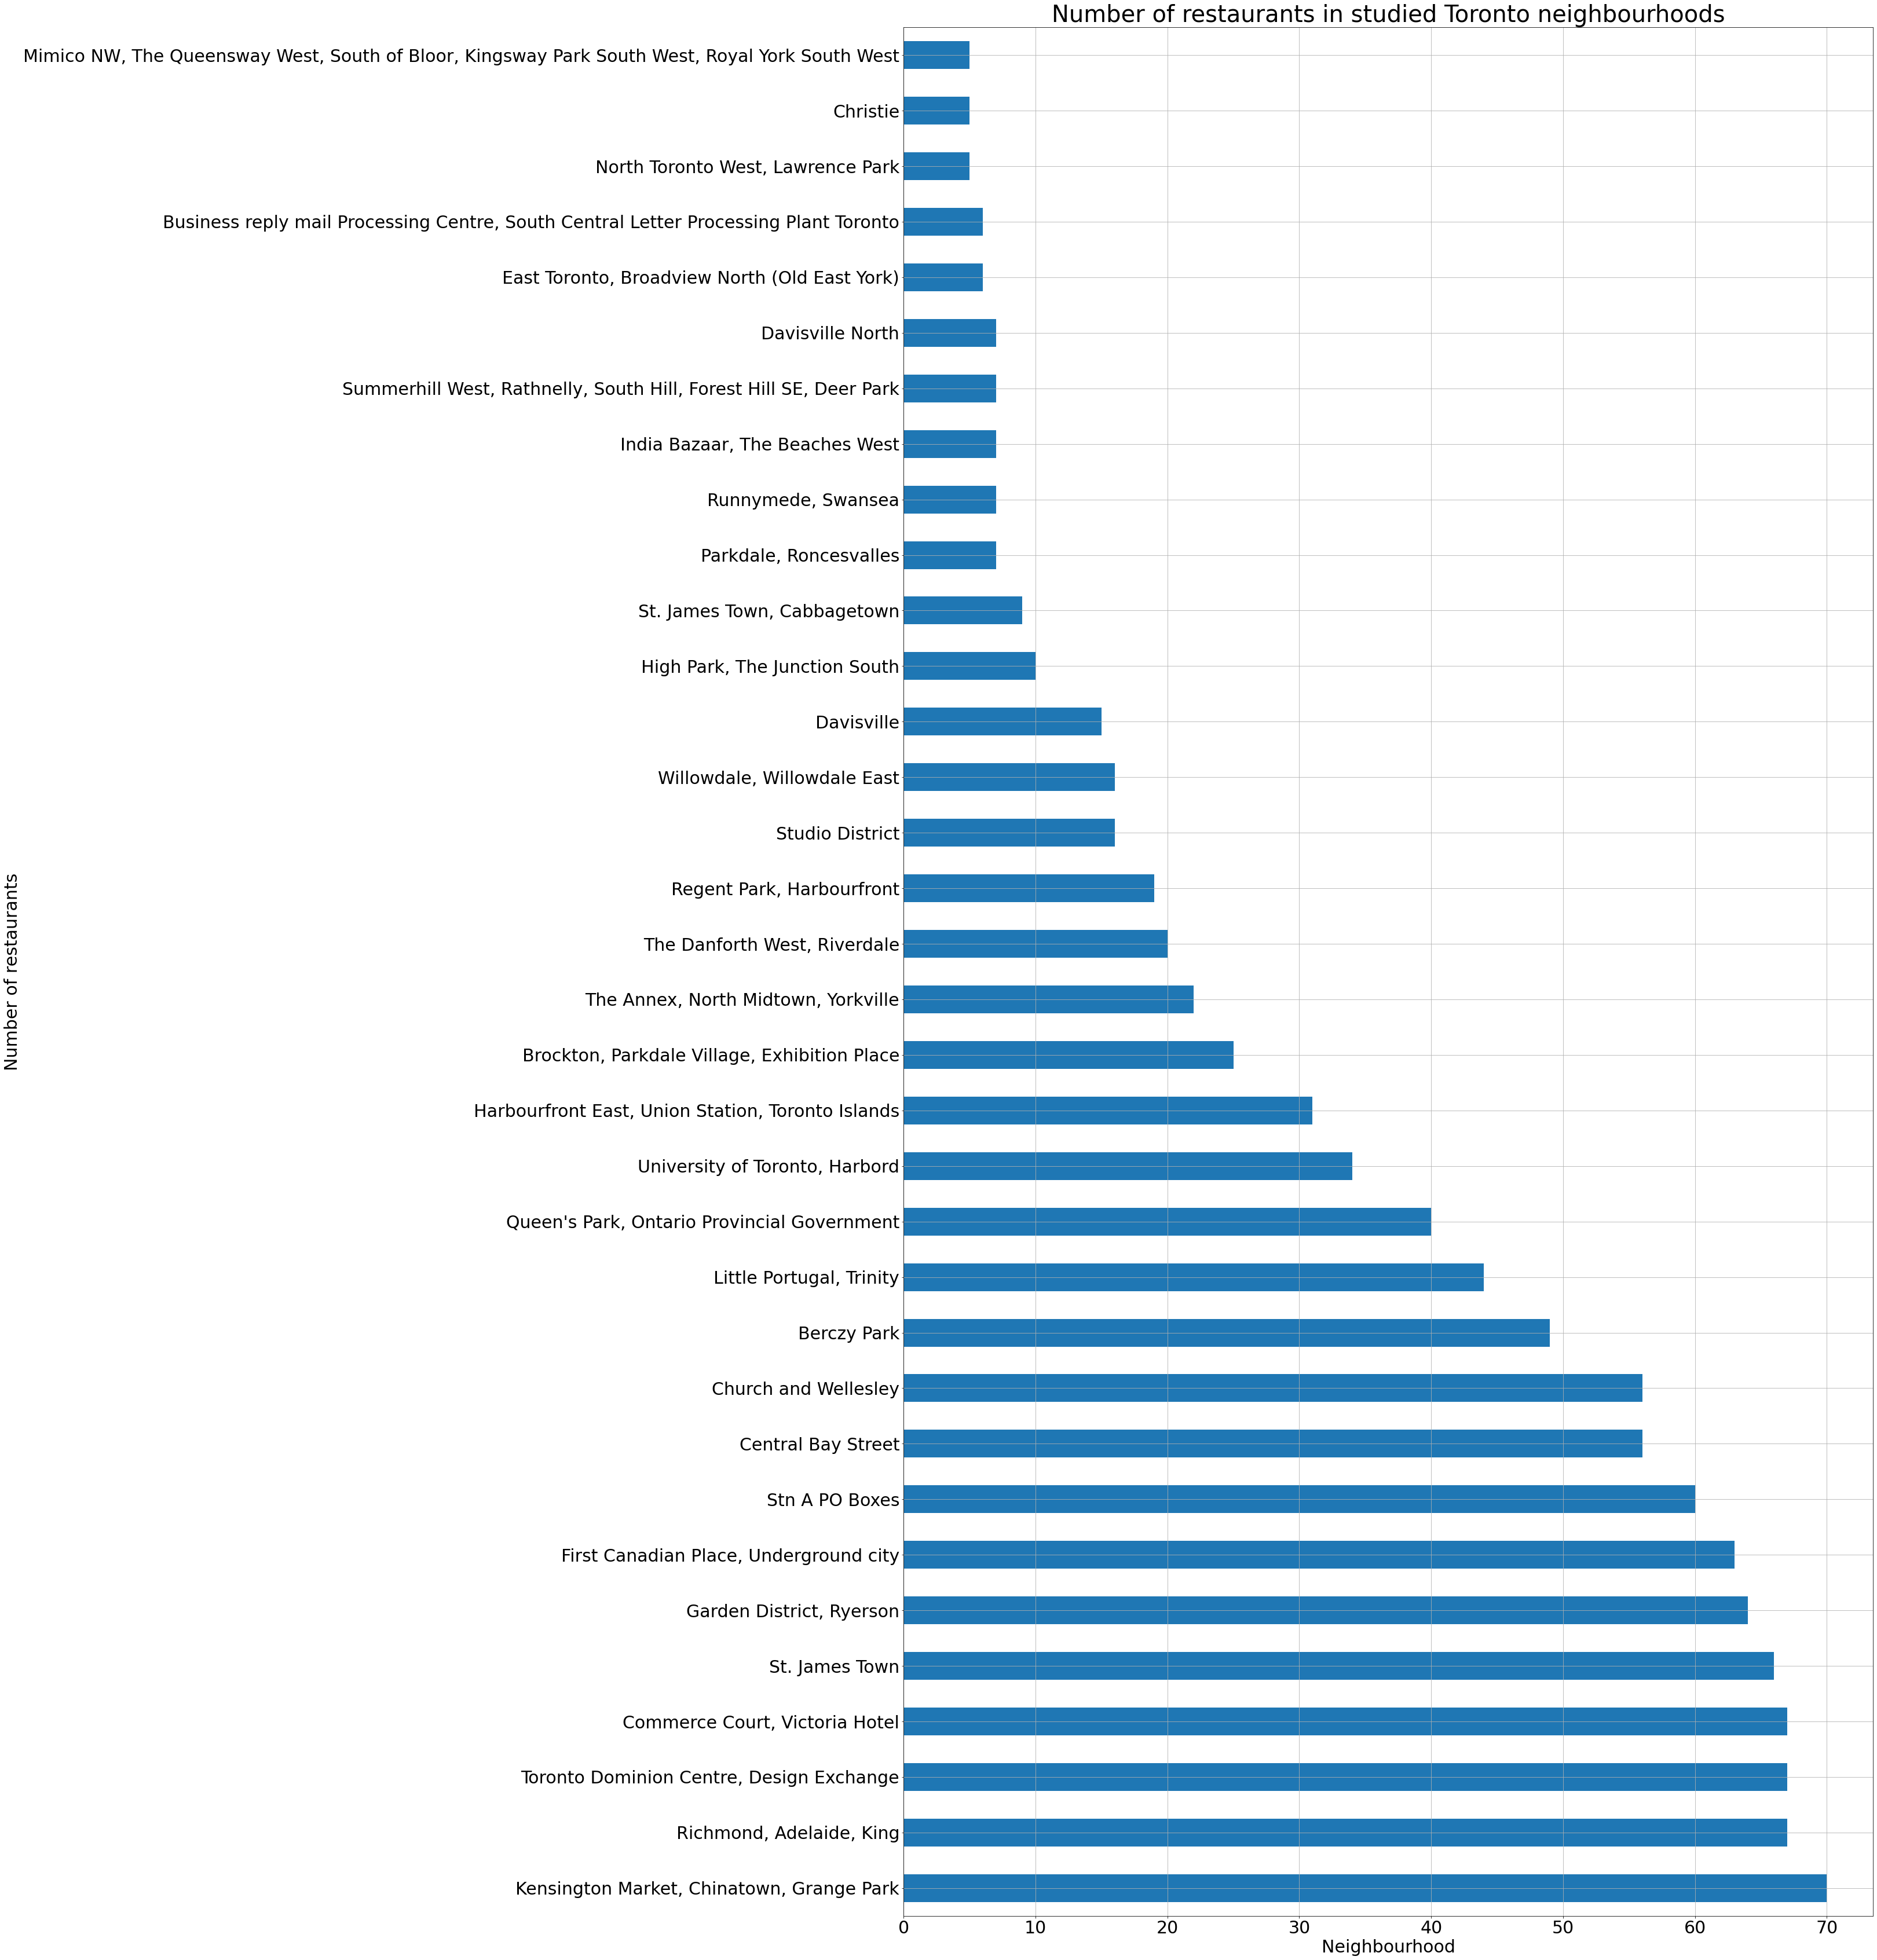

In [12]:
restaurant_in_neighbourhoods = toronto_venues.groupby('Neighbourhood').count()
restaurant_in_neighbourhoods = pd.DataFrame(restaurant_in_neighbourhoods.iloc[:,0].copy())
restaurant_in_neighbourhoods.rename(columns={'Neighbourhood Latitude':'Number of restaurants'},inplace=True)
restaurant_in_neighbourhoods
restaurant_in_neighbourhoods = restaurant_in_neighbourhoods[restaurant_in_neighbourhoods['Number of restaurants'] > 4]
restaurant_in_neighbourhoods.sort_values(['Number of restaurants'],ascending=False, inplace=True)
plt.figure(figsize=(30,60))
restaurant_in_neighbourhoods['Number of restaurants'].plot(kind='barh',fontsize=30)
plt.title('Number of restaurants in studied Toronto neighbourhoods',fontsize=40)
plt.xlabel('Neighbourhood',fontsize=30)
plt.ylabel('Number of restaurants',fontsize=30)
plt.grid()
plt.show()

In [13]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 89 uniques categories.


Create a dataframe with the restaurant categories grouped together and its average number of likes and number of venues.

In [14]:
venues_count = pd.DataFrame(toronto_venues.groupby('Venue Category').count()['Neighbourhood'])
venues_count.rename(columns={'Neighbourhood':'Number of venues'},inplace=True)
venues_likes = toronto_venues.groupby('Venue Category').mean()
venues_likes.rename(columns={'Venue likes':'Mean Venue Likes'},inplace=True)
venues_likes_count = pd.merge(venues_likes,venues_count,on='Venue Category')
venues_likes_count.drop(['Neighbourhood Latitude','Neighbourhood Longitude','Venue Latitude','Venue Longitude'],axis=1, inplace=True)
venues_likes_count


,Mean Venue Likes,Number of venues
Venue Category,,
Afghan Restaurant,43.000000,2
American Restaurant,124.538462,39
Arepa Restaurant,67.000000,2
Asian Restaurant,44.785714,14
BBQ Joint,113.000000,6
Bagel Shop,35.000000,6
Bakery,60.725000,40
Belgian Restaurant,253.000000,2
Bistro,72.285714,7


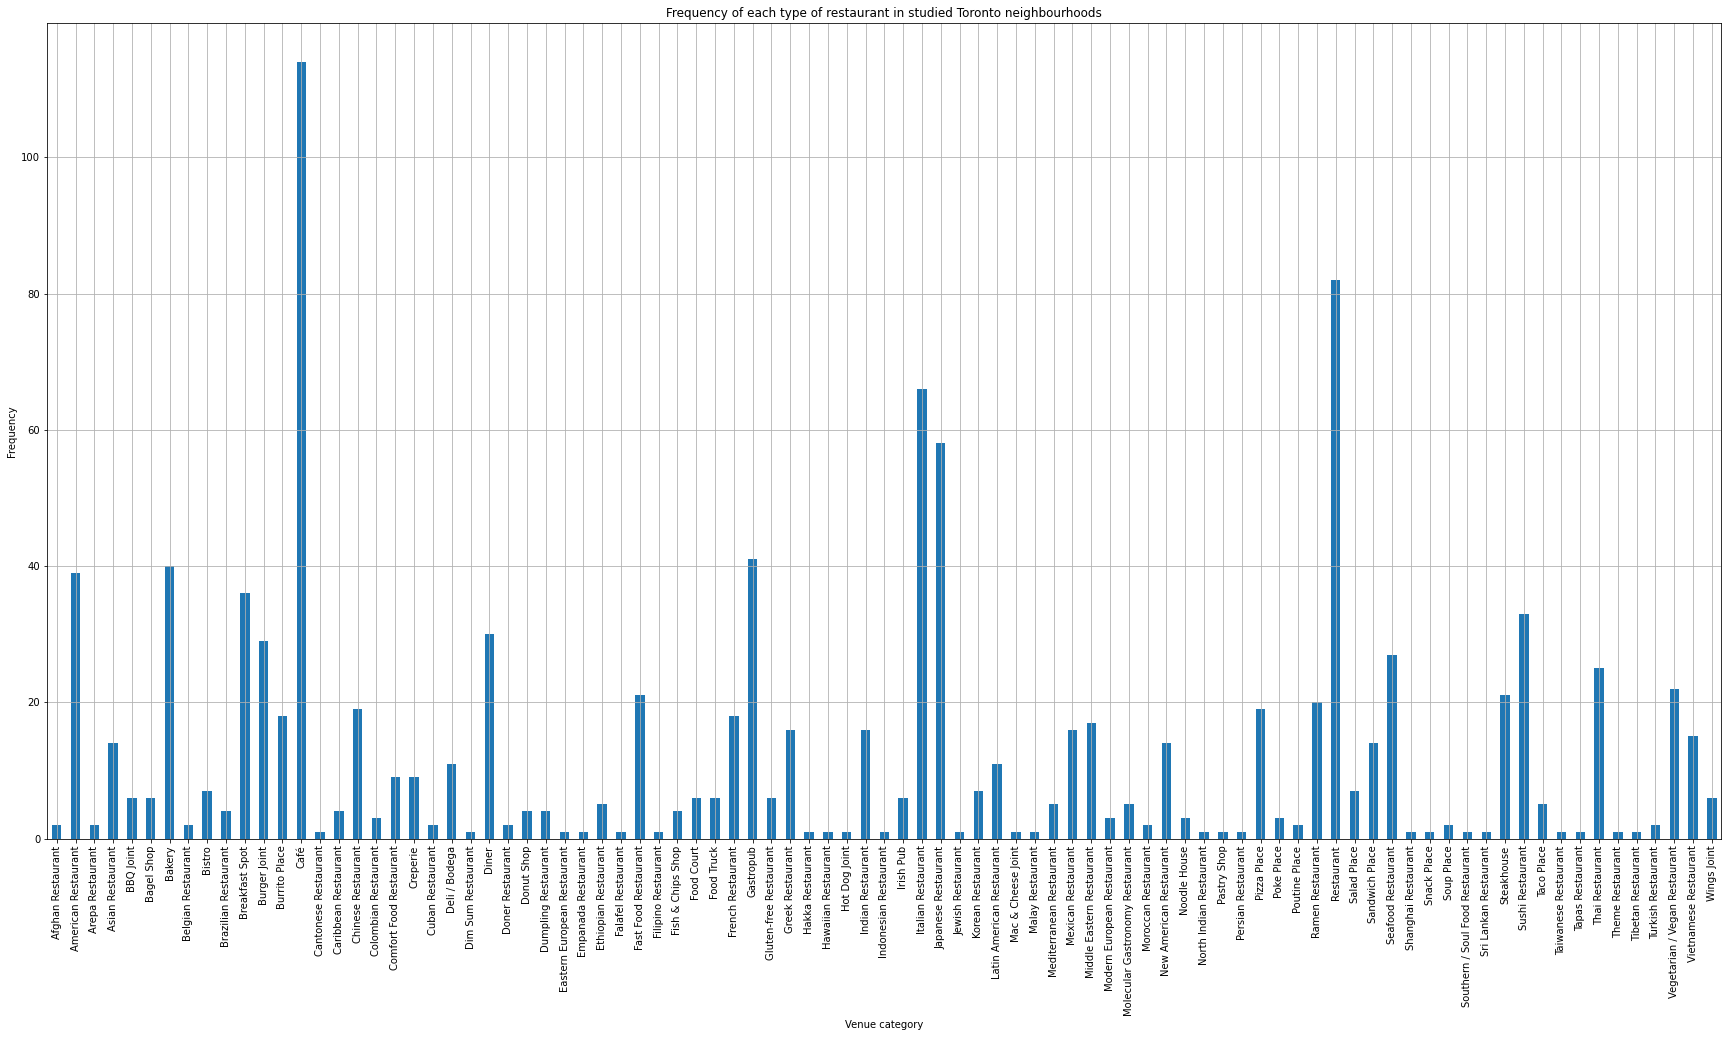

In [15]:
plt.figure(figsize=(30,15))
venues_likes_count['Number of venues'].plot(kind='bar')
plt.title('Frequency of each type of restaurant in studied Toronto neighbourhoods')
plt.xlabel('Venue category')
plt.ylabel('Frequency')
plt.grid()
plt.show()

The category 'restaurant' is ambiguous and it does not give information about the restaurant type. Then, it will be neglected.

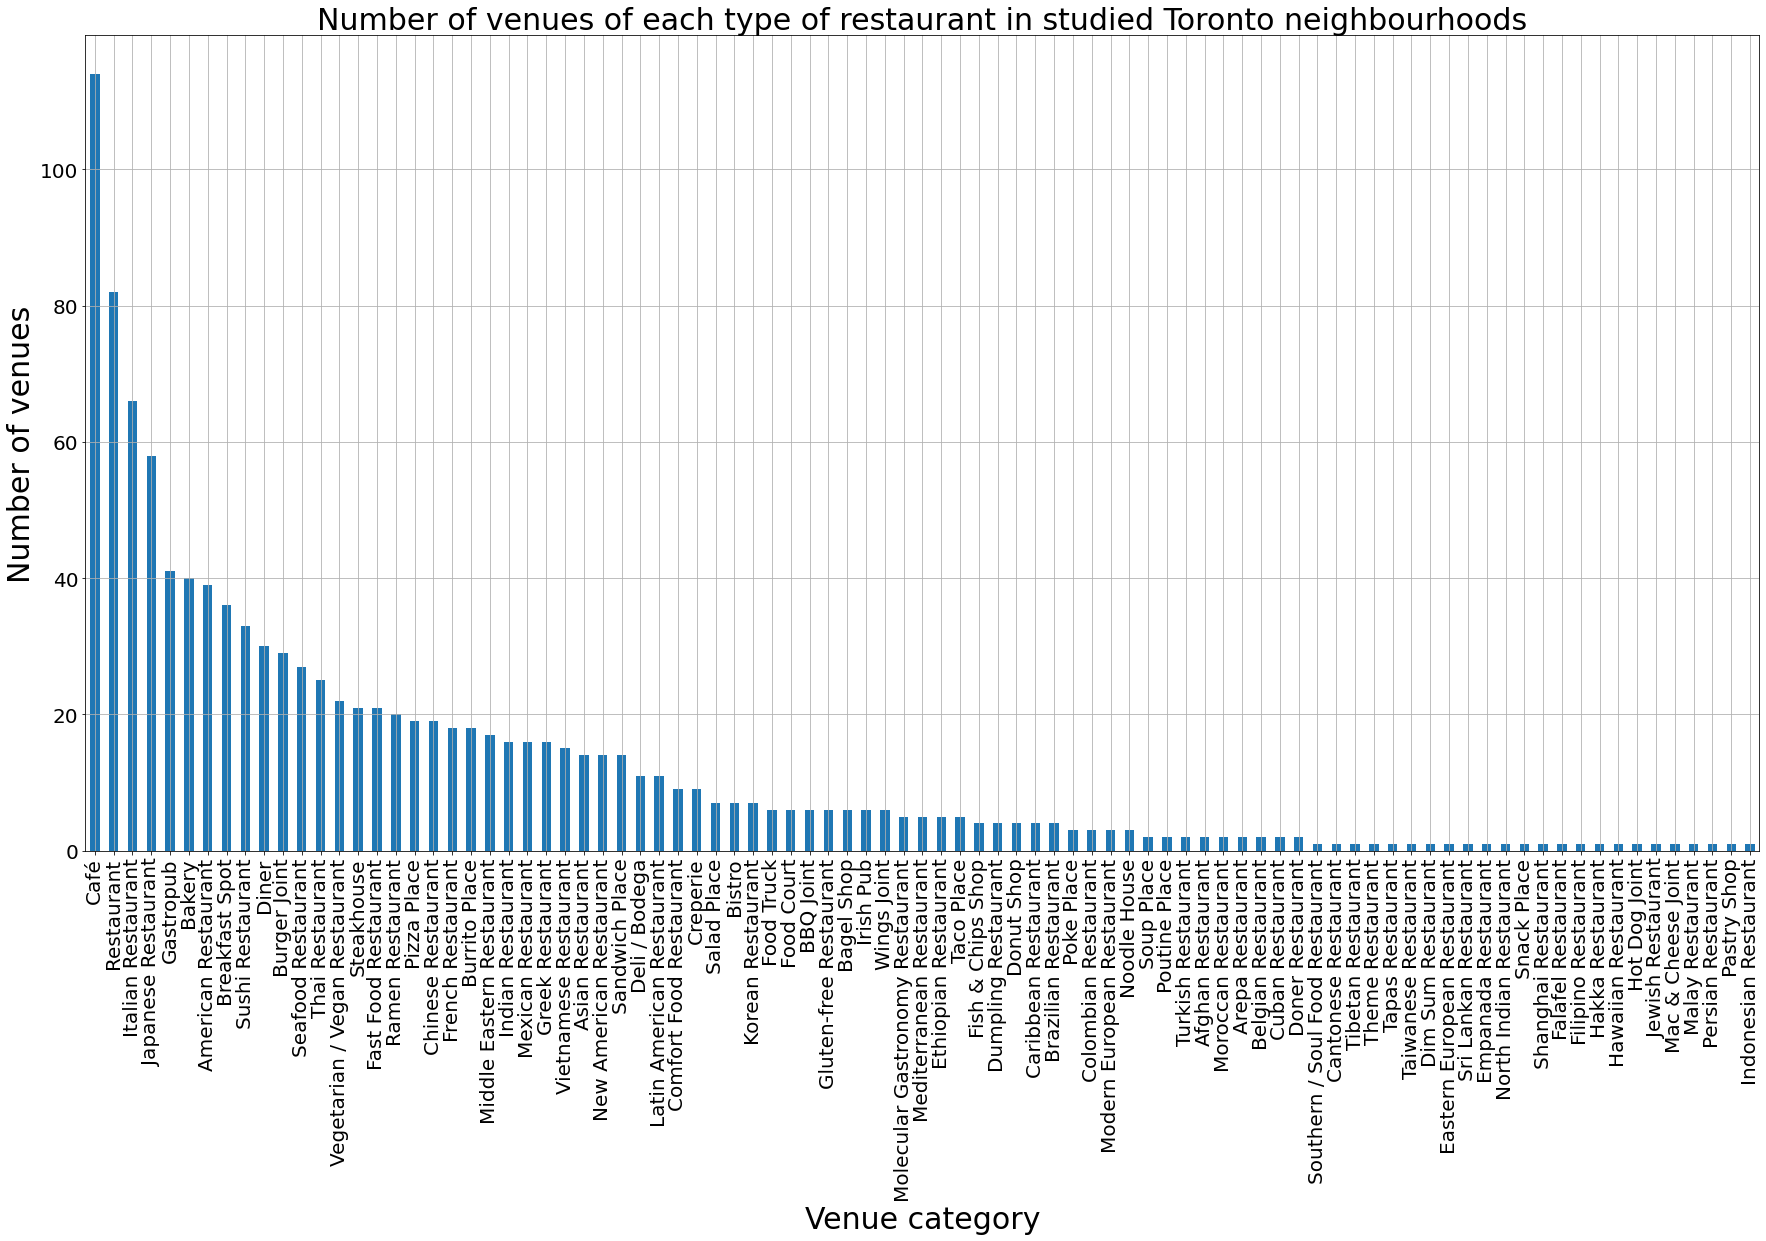

In [16]:
#venues_likes_count.drop('Restaurant',inplace = True)
venues_likes_count.sort_values(['Number of venues'],ascending=False, inplace=True)
plt.figure(figsize=(30,15))
venues_likes_count['Number of venues'].plot(kind='bar',fontsize=20)
plt.title('Number of venues of each type of restaurant in studied Toronto neighbourhoods',fontsize=30)
plt.xlabel('Venue category',fontsize=30)
plt.ylabel('Number of venues',fontsize=30)
plt.grid()
plt.show()

Most common restaurants are Café, Italian Restaurant and Japanese Restaurant.

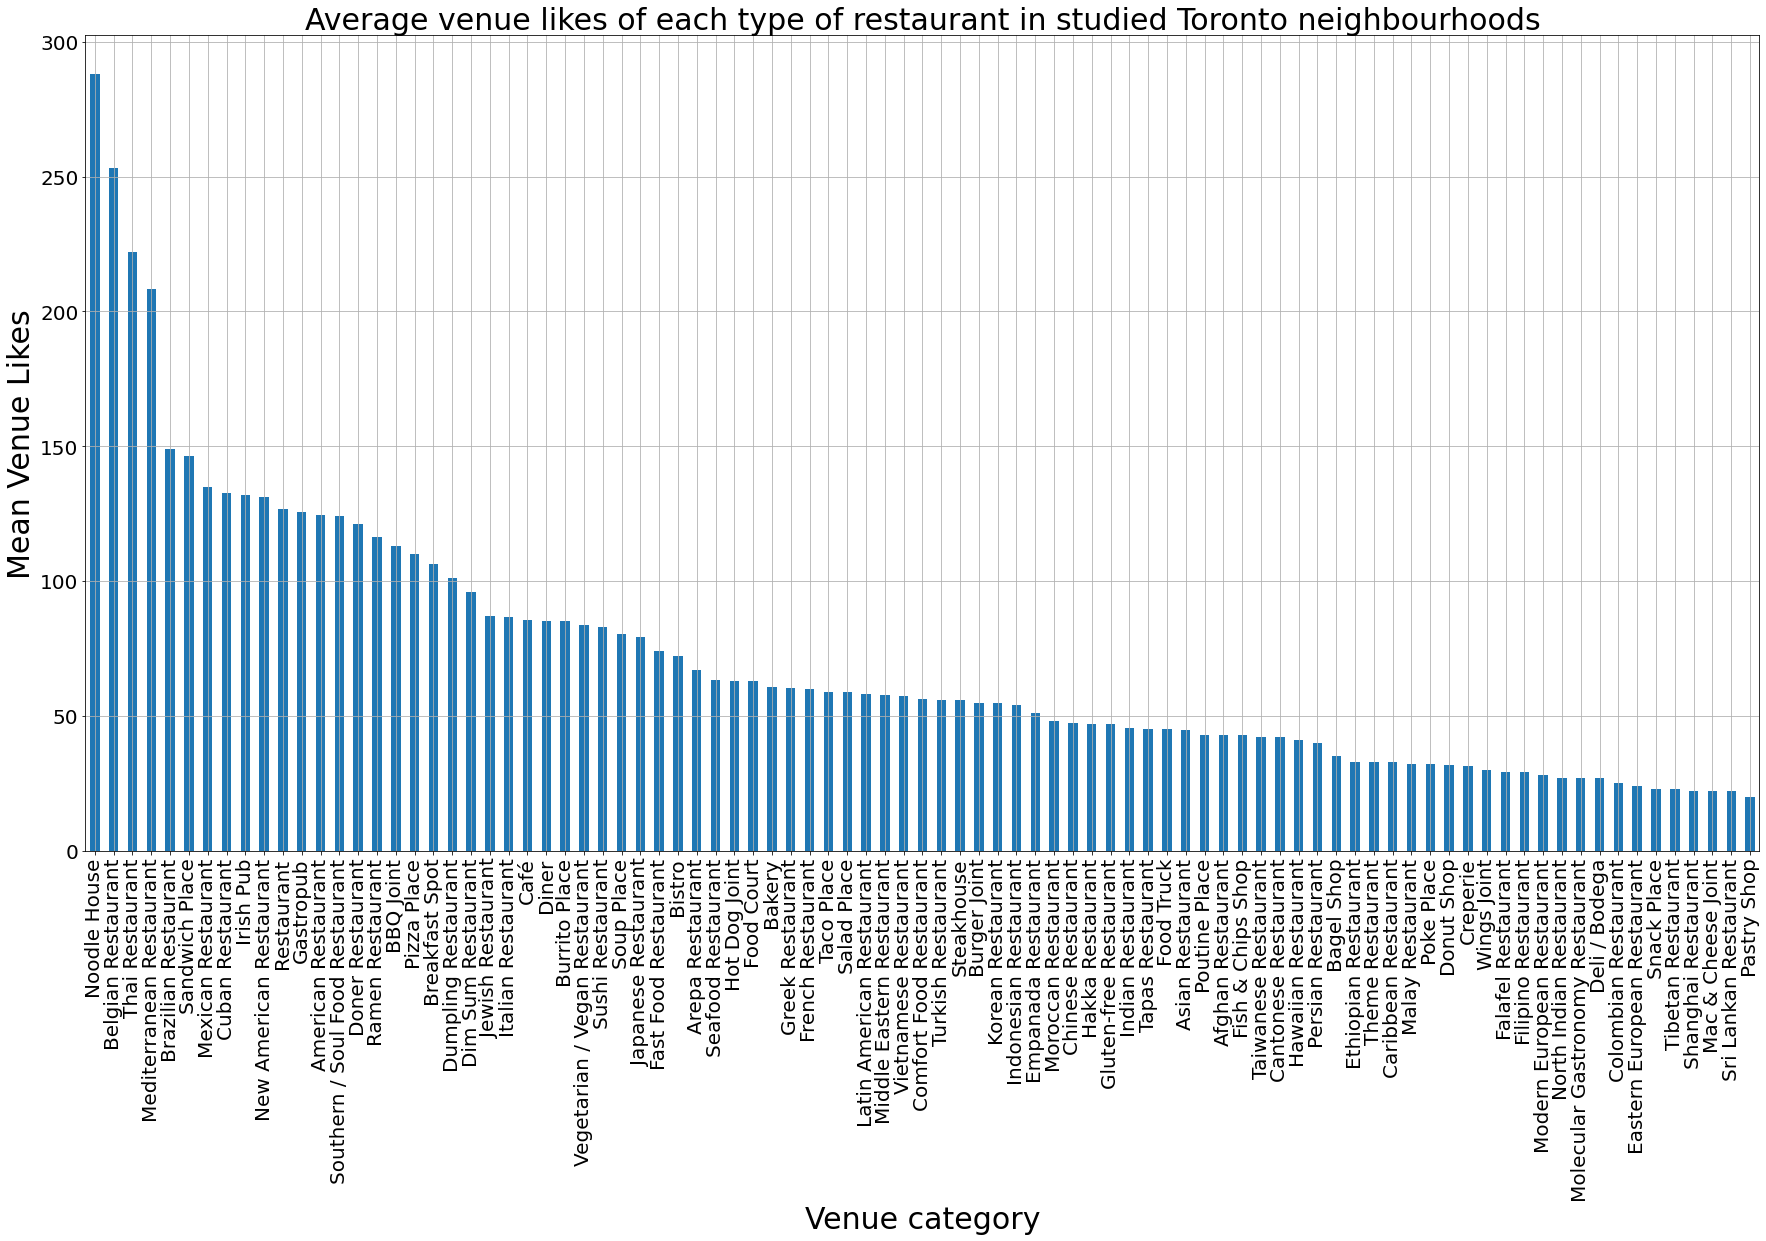

In [17]:
venues_likes_count.sort_values(['Mean Venue Likes'],ascending=False, inplace=True)
plt.figure(figsize=(30,15))
venues_likes_count['Mean Venue Likes'].plot(kind='bar',fontsize=20)
plt.title('Average venue likes of each type of restaurant in studied Toronto neighbourhoods',fontsize=30)
plt.xlabel('Venue category',fontsize=30)
plt.ylabel('Mean Venue Likes',fontsize=30)
plt.grid()
plt.show()

The venue categories that people like most are Noodle House, Belgian Restaurant and Thai Restaurant.

<Figure size 2160x1080 with 0 Axes>

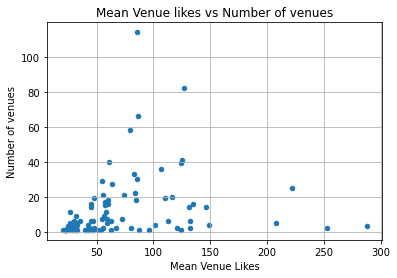

0.2118912505323997

In [18]:
plt.figure(figsize=(30,15))
venues_likes_count.plot(kind='scatter',x='Mean Venue Likes',y='Number of venues')
plt.title('Mean Venue likes vs Number of venues')
plt.xlabel('Mean Venue Likes')
plt.ylabel('Number of venues')
plt.grid()
plt.show()

from scipy import stats
pearson_coef, p_value = stats.pearsonr(venues_likes_count['Mean Venue Likes'],venues_likes_count['Number of venues'])
pearson_coef


From the previous scatter, it can be concluded that:
- Café is the most typical venue category with an average number of likes of 85.
- Noddle house, Belgian Restaurant and Mediterranean restaurant have an average number of likes of more than 200, whereas there are very few of them. (3, 2 and 5 respectively)
- Thai restaurants have an average number of likes higher than 200 while there are 25 of this type in Toronto.

In [19]:
toronto_venues = toronto_venues[toronto_venues['Venue Category']!='Restaurant']
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue likes
6,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery,48
8,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot,36
9,"Regent Park, Harbourfront",43.65426,-79.360636,Souk Tabule,43.653756,-79.354390,Mediterranean Restaurant,53
10,"Regent Park, Harbourfront",43.65426,-79.360636,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot,55
11,"Regent Park, Harbourfront",43.65426,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant,190


## 4. Clustering considering mean venue likes and number of restaurants per neighbourhood

Adding dummy variables

In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Venue likes'] =  toronto_venues['Venue likes']
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Gastropub,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pastry Shop,Persian Restaurant,Pizza Place,Poke Place,Poutine Place,Ramen Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Snack Place,Soup Place,Southern / Soul Food Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Venue likes
6,"Regent Park, Harbourfront",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48
8,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36
9,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53
10,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55
11,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,190


In [21]:
data_frame_shape = toronto_onehot.shape
data_frame_shape

(1015, 90)

Adding average medium likes and number of venues per neighbourhood

In [22]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
venues_count = pd.DataFrame(toronto_venues.groupby('Neighbourhood').count()['Venue Latitude'])
venues_count.rename(columns={'Venue Latitude':'Number of venues'},inplace=True)
toronto_grouped_count = pd.merge(toronto_grouped,venues_count,on='Neighbourhood')
toronto_grouped_count.head()
toronto_grouped_count = toronto_grouped_count[toronto_grouped_count['Number of venues'] > 4].reset_index(drop=True)
toronto_grouped_count.head()

,Neighbourhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Gastropub,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pastry Shop,Persian Restaurant,Pizza Place,Poke Place,Poutine Place,Ramen Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Snack Place,Soup Place,Southern / Soul Food Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Venue likes,Number of venues
0,Berczy Park,0.000000,0.046512,0.0,0.0,0.0,0.023256,0.023256,0.023256,0.023256,0.0,0.046512,0.000000,0.023256,0.116279,0.0,0.0,0.000000,0.0,0.023256,0.023256,0.0,0.023256,0.0,0.023256,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.023256,0.0,0.0,0.0,0.023256,0.046512,0.046512,0.0,0.023256,0.0,0.000000,0.0,0.023256,0.0,0.023256,0.069767,0.069767,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.023256,0.023256,0.023256,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.023256,0.000000,0.046512,0.0,0.0,0.0,0.0,0.0,0.000000,0.046512,0.0,0.0,0.023256,0.023256,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,80.465116,43
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.047619,0.0,0.0,0.0,0.000000,0.095238,0.000000,0.000000,0.0,0.047619,0.047619,0.047619,0.095238,0.0,0.0,0.000000,0.0,0.047619,0.000000,0.0,0.000000,0.0,0.047619,0.0,0.000000,0.0,0.0,0.0,0.047619,0.0,0.000000,0.0,0.0,0.0,0.000000,0.047619,0.000000,0.0,0.000000,0.0,0.047619,0.0,0.000000,0.0,0.000000,0.047619,0.047619,0.0,0.000000,0.0,0.0,0.0,0.0,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.047619,0.000000,0.000000,0.047619,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.047619,0.0,0.047619,0.047619,0.000000,70.904762,21
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.166667,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.166667,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,71.500000,6
3,Central Bay Street,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.037037,0.000000,0.000000,0.0,0.037037,0.055556,0.018519,0.111111,0.0,0.0,0.074074,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.037037,0.0,0.018519,0.0,0.0,0.0,0.000000,0.0,0.018519,0.0,0.0,0.0,0.000000,0.018519,0.037037,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.055556,0.074074,0.0,0.018519,0.0,0.0,0.0,0.0,0.018519,0.037037,0.018519,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.018519,0

In [23]:
num_top_venues = 3

for hood in toronto_grouped_count['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped_count[toronto_grouped_count['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:(data_frame_shape[1]-1)]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                 venue  freq
0                 Café  0.12
1   Italian Restaurant  0.07
2  Japanese Restaurant  0.07


----Brockton, Parkdale Village, Exhibition Place----
           venue  freq
0         Bakery  0.10
1           Café  0.10
2  Poutine Place  0.05


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0         Burrito Place  0.33
1    Italian Restaurant  0.17
2  Fast Food Restaurant  0.17


----Central Bay Street----
                 venue  freq
0                 Café  0.11
1  Japanese Restaurant  0.07
2   Chinese Restaurant  0.07


----Church and Wellesley----
                 venue  freq
0  Japanese Restaurant  0.12
1                 Café  0.08
2       Sandwich Place  0.08


----Commerce Court, Victoria Hotel----
                 venue  freq
0                 Café  0.11
1  Japanese Restaurant  0.07
2            Gastropub  0.07


----Davisville----
                   venue  freq
0

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:(data_frame_shape[1]-1)]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped_count['Neighbourhood']

for ind in np.arange(toronto_grouped_count.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped_count.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted['Venue likes'] = toronto_grouped_count['Venue likes']    
neighborhoods_venues_sorted['Number of venues'] = toronto_grouped_count['Number of venues']
neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Venue likes,Number of venues
0,Berczy Park,Café,Italian Restaurant,Japanese Restaurant,80.465116,43
1,"Brockton, Parkdale Village, Exhibition Place",Café,Bakery,Burrito Place,70.904762,21
2,"Business reply mail Processing Centre, South C...",Burrito Place,Fast Food Restaurant,Italian Restaurant,71.500000,6
3,Central Bay Street,Café,Japanese Restaurant,Chinese Restaurant,101.592593,54
4,Church and Wellesley,Japanese Restaurant,Café,Sandwich Place,70.653846,52


In [26]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped_count.drop(['Neighbourhood'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 3, 3, 4, 0, 4, 1, 1, 1, 2, 2, 3, 1, 1, 4, 0, 1, 3, 0, 3, 2, 1,
       4, 3, 4, 1, 1, 1, 1, 4, 0, 1], dtype=int32)

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data 
toronto_merged = toronto_merged.merge(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged 

,Postalcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Venue likes,Number of venues
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3,Italian Restaurant,Café,Bakery,90.125000,16
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Café,Japanese Restaurant,Diner,65.368421,38
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Japanese Restaurant,Diner,Italian Restaurant,119.745763,59
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,4,Café,Italian Restaurant,Gastropub,95.275862,58
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Café,Italian Restaurant,Japanese Restaurant,80.465116,43
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,4,Café,Japanese Restaurant,Chinese Restaurant,101.592593,54
6,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,2,Café,Japanese Restaurant,Italian Restaurant,117.079365,63
7,M4J,East York,"East Toronto, Broadview North (Old East York)",43.685347,-79.338106,1,Café,Pizza Place,Turkish Restaurant,52.000000,6
8,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,3,Italian Restaurant,Café,American Restaurant,77.230769,26
9,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,0,Café,Bakery,Italian Restaurant,80.900000,40


In [28]:
map_clusters = folium.Map(location=[latitude,longitude],zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


Check map in https://eu-gb.dataplatform.cloud.ibm.com/analytics/notebooks/v2/20c20396-bee3-4361-8b55-080ff402200a/view?access_token=2373ebb4fdc002c5cd420fe85b91670b67e49950f895733ea3bd63d4cf011065

In [29]:
toronto_merged[toronto_merged['Cluster Labels'] == 0].loc[:,['Neighbourhood','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','Venue likes','Number of venues']]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Venue likes,Number of venues
1,"Queen's Park, Ontario Provincial Government",Café,Japanese Restaurant,Diner,65.368421,38
4,Berczy Park,Café,Italian Restaurant,Japanese Restaurant,80.465116,43
9,"Little Portugal, Trinity",Café,Bakery,Italian Restaurant,80.900000,40
23,"University of Toronto, Harbord",Thai Restaurant,Bakery,Sushi Restaurant,60.516129,31
30,Church and Wellesley,Japanese Restaurant,Café,Sandwich Place,70.653846,52


In [30]:
toronto_merged[toronto_merged['Cluster Labels'] == 1].loc[:,['Neighbourhood','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','Venue likes','Number of venues']]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Venue likes,Number of venues
7,"East Toronto, Broadview North (Old East York)",Café,Pizza Place,Turkish Restaurant,52.000000,6
10,"The Danforth West, Riverdale",Greek Restaurant,Café,Burger Joint,58.300000,20
13,"India Bazaar, The Beaches West",Indian Restaurant,Fast Food Restaurant,Asian Restaurant,59.142857,7
15,Studio District,Bakery,Diner,Latin American Restaurant,48.800000,15
16,"Willowdale, Willowdale East",Ramen Restaurant,Sushi Restaurant,Korean Restaurant,46.357143,14
17,Davisville North,Café,Indian Restaurant,Vegetarian / Vegan Restaurant,48.142857,7
18,"High Park, The Junction South",Café,Indian Restaurant,Vietnamese Restaurant,59.888889,9
19,"North Toronto West, Lawrence Park",Café,Diner,Ramen Restaurant,45.200000,5
20,"The Annex, North Midtown, Yorkville",Italian Restaurant,Thai Restaurant,Wings Joint,58.318182,22
22,Davisville,Café,Indian Restaurant,Taco Place,41.785714,14


In [31]:
toronto_merged[toronto_merged['Cluster Labels'] == 2].loc[:,['Neighbourhood','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','Venue likes','Number of venues']]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Venue likes,Number of venues
2,"Garden District, Ryerson",Japanese Restaurant,Diner,Italian Restaurant,119.745763,59
6,"Richmond, Adelaide, King",Café,Japanese Restaurant,Italian Restaurant,117.079365,63
29,"First Canadian Place, Underground city",Café,American Restaurant,Japanese Restaurant,112.982759,58


In [32]:
toronto_merged[toronto_merged['Cluster Labels'] == 3].loc[:,['Neighbourhood','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','Venue likes','Number of venues']]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Venue likes,Number of venues
0,"Regent Park, Harbourfront",Italian Restaurant,Café,Bakery,90.125000,16
8,"Harbourfront East, Union Station, Toronto Islands",Italian Restaurant,Café,American Restaurant,77.230769,26
12,"Brockton, Parkdale Village, Exhibition Place",Café,Bakery,Burrito Place,70.904762,21
21,"Parkdale, Roncesvalles",Pizza Place,American Restaurant,Cuban Restaurant,90.857143,7
28,"St. James Town, Cabbagetown",Diner,Japanese Restaurant,Gastropub,69.666667,9
31,"Business reply mail Processing Centre, South C...",Burrito Place,Fast Food Restaurant,Italian Restaurant,71.500000,6


In [33]:
toronto_merged[toronto_merged['Cluster Labels'] == 4].loc[:,['Neighbourhood','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','Venue likes','Number of venues']]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Venue likes,Number of venues
3,St. James Town,Café,Italian Restaurant,Gastropub,95.275862,58
5,Central Bay Street,Café,Japanese Restaurant,Chinese Restaurant,101.592593,54
11,"Toronto Dominion Centre, Design Exchange",Café,Japanese Restaurant,Italian Restaurant,103.327869,61
14,"Commerce Court, Victoria Hotel",Café,Japanese Restaurant,American Restaurant,104.377049,61
25,"Kensington Market, Chinatown, Grange Park",Café,Vegetarian / Vegan Restaurant,Mexican Restaurant,84.347826,69
27,Stn A PO Boxes,Café,American Restaurant,Gastropub,91.927273,55
